In [1]:
from __future__ import print_function
import numpy as np
from scipy import optimize as opt
import cntk as C
from PIL import Image
import requests
import h5py
import os
%matplotlib inline
import matplotlib.pyplot as plt

import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # (only needed for our build system)
C.cntk_py.set_fixed_random_seed(1)

C:\Users\Dell\AppData\Local\Programs\Python\Python36\Lib\site-packages\cntk\cntk_py_init.py:84: UserWarning: 

################################################ Missing optional dependency (GPU-Specific) ################################################
   CNTK may crash if the component that depends on those dependencies is loaded.
   Visit https://docs.microsoft.com/en-us/cognitive-toolkit/Setup-Windows-Python#optional-gpu-specific-packages for more information.
############################################################################################################################################
If you intend to use CNTK without GPU support, you can ignore the (likely) GPU-specific warning!
############################################################################################################################################

  warnings.warn(WARNING_MSG_GPU_ONLY % ('GPU-Specific', 'https://docs.microsoft.com/en-us/cognitive-toolkit/Setup-Windows-Python#optional-gpu-specific-pa

In [2]:
def download(url, filename):
    response = requests.get(url, stream=True)
    with open(filename, 'wb') as handle:
        for data in response.iter_content(chunk_size=2**20):
            if data: handle.write(data)


def load_vgg(path):
    f = h5py.File(path)
    layers = []
    for k in range(f.attrs['nb_layers']):
        g = f['layer_{}'.format(k)]
        n = g.attrs['nb_params']
        layers.append([g['param_{}'.format(p)][:] for p in range(n)])
    f.close()
    return layers

# Check for an environment variable defined in CNTK's test infrastructure
envvar = 'CNTK_EXTERNAL_TESTDATA_SOURCE_DIRECTORY'
def is_test(): return envvar in os.environ

path = 'vgg16_weights.bin'
url = 'https://cntk.ai/jup/models/vgg16_weights.bin'
# We check for the model locally
if not os.path.exists(path):
    # If not there we might be running in CNTK's test infrastructure
    if is_test():
        path = os.path.join(os.environ[envvar],'PreTrainedModels','Vgg16','v0',path)
    else:
        #If neither is true we download the file from the web
        print('downloading VGG model (~0.5GB)')
        download(url, path)
layers = load_vgg(path)
print('loaded VGG model')

downloading VGG model (~0.5GB)
loaded VGG model


In [3]:
# A convolutional layer in the VGG network
def vggblock(x, arrays, layer_map, name):
    f = arrays[0]
    b = arrays[1]
    k = C.constant(value=f)
    t = C.constant(value=np.reshape(b, (-1, 1, 1)))
    y = C.relu(C.convolution(k, x, auto_padding=[False, True, True]) + t)
    layer_map[name] = y
    return y

# A pooling layer in the VGG network
def vggpool(x):
    return C.pooling(x, C.AVG_POOLING, (2, 2), (2, 2))


# Build the graph for the VGG network (excluding fully connected layers)
def model(x, layers):
    model_layers = {}
    def convolutional(z): return len(z) == 2 and len(z[0].shape) == 4
    conv = [layer for layer in layers if convolutional(layer)]
    cnt = 0
    num_convs = {1: 2, 2: 2, 3: 3, 4: 3, 5: 3}
    for outer in range(1,6):
        for inner in range(num_convs[outer]):
            x = vggblock(x, conv[cnt], model_layers, 'conv%d_%d' % (outer, 1+inner))
            cnt += 1
        x = vggpool(x)

    return x, C.combine([model_layers[k] for k in sorted(model_layers.keys())])

In [4]:
def flatten(x):
    assert len(x.shape) >= 3
    return C.reshape(x, (x.shape[-3], x.shape[-2] * x.shape[-1]))


def gram(x):
    features = C.minus(flatten(x), C.reduce_mean(x))
    return C.times_transpose(features, features)


def npgram(x):
    features = np.reshape(x, (-1, x.shape[-2]*x.shape[-1])) - np.mean(x)
    return features.dot(features.T)


def style_loss(a, b):
    channels, x, y = a.shape
    assert x == y
    A = gram(a)
    B = npgram(b)
    return C.squared_error(A, B)/(channels**2 * x**4)


def content_loss(a,b):
    channels, x, y = a.shape
    return C.squared_error(a, b)/(channels*x*y)


def total_variation_loss(x):
    xx = C.reshape(x, (1,)+x.shape)
    delta = np.array([-1, 1], dtype=np.float32)
    kh = C.constant(value=delta.reshape(1, 1, 1, 1, 2))
    kv = C.constant(value=delta.reshape(1, 1, 1, 2, 1))
    dh = C.convolution(kh, xx, auto_padding=[False])
    dv = C.convolution(kv, xx, auto_padding=[False])
    avg = 0.5 * (C.reduce_mean(C.square(dv)) + C.reduce_mean(C.square(dh)))
    return avg

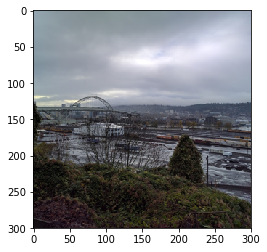

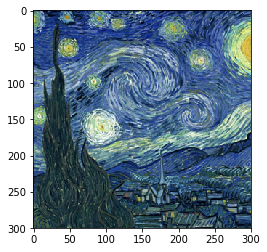

In [5]:
style_path = 'style.jpg'
content_path = 'content.jpg'

start_from_random = False
content_weight = 5.0
style_weight = 1.0
decay = 0.5

if is_test():
    outer = 2
    inner = 2
    SIZE = 64
else:
    outer = 10
    inner = 20
    SIZE = 300

SHIFT = np.reshape([103.939, 116.779, 123.68], (3, 1, 1)).astype('f')

def load_image(path):
    with Image.open(path) as pic:
        hw = pic.size[0] / 2
        hh = pic.size[1] / 2
        mh = min(hw,hh)
        cropped = pic.crop((hw - mh, hh - mh, hw + mh, hh + mh))
        array = np.array(cropped.resize((SIZE,SIZE), Image.BICUBIC), dtype=np.float32)
        return np.ascontiguousarray(np.transpose(array, (2,0,1)))-SHIFT

def save_image(img, path):
    sanitized_img = np.maximum(0, np.minimum(255, img+SHIFT))
    pic = Image.fromarray(np.uint8(np.transpose(sanitized_img, (1, 2, 0))))
    pic.save(path)

def ordered_outputs(f, binding):
    _, output_dict = f.forward(binding, f.outputs)
    return [np.squeeze(output_dict[out]) for out in f.outputs]

# download the images if they are not available locally
for local_path in content_path, style_path:
    if not os.path.exists(local_path):
        download('https://cntk.ai/jup/%s' % local_path, local_path)

# Load the images
style   = load_image(style_path)
content = load_image(content_path)

# Display the images
for img in content, style:
    plt.figure()
    plt.imshow(np.asarray(np.transpose(img+SHIFT, (1, 2, 0)), dtype=np.uint8))

# Push the images through the VGG network
# First define the input and the output
y = C.input_variable((3, SIZE, SIZE), needs_gradient=True)
z, intermediate_layers = model(y, layers)
# Now get the activations for the two images
content_activations = ordered_outputs(intermediate_layers, {y: [[content]]})
style_activations = ordered_outputs(intermediate_layers, {y: [[style]]})
style_output = np.squeeze(z.eval({y: [[style]]}))

# Finally define the loss
n = len(content_activations)
total = (1-decay**(n+1))/(1-decay) # makes sure that changing the decay does not affect the magnitude of content/style
loss = (1.0/total * content_weight * content_loss(y, content)
         + 1.0/total * style_weight * style_loss(z, style_output)
         + total_variation_loss(y))

for i in range(n):
    loss = (loss
        + decay**(i+1)/total * content_weight * content_loss(intermediate_layers.outputs[i], content_activations[i])
        + decay**(n-i)/total * style_weight   *   style_loss(intermediate_layers.outputs[i], style_activations[i]))

In [8]:
y = C.input_variable((3, SIZE, SIZE), needs_gradient=True)

objective : 54985.918
objective : 45304.31
objective : 42615.082
objective : 41535.707
objective : 40895.54
objective : 40493.758
objective : 40246.902
objective : 40084.88
objective : 39962.99
objective : 39871.0


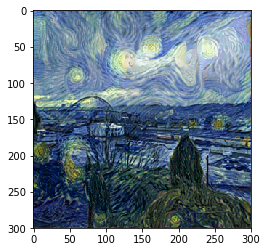

In [9]:
# utility to convert a vector to an image
def vec2img(x):
    d = np.round(np.sqrt(x.size / 3)).astype('i')
    return np.reshape(x.astype(np.float32), (3, d, d))

# utility to convert an image to a vector
def img2vec(img):
    return img.flatten().astype(np.float64)

# utility to compute the value and the gradient of f at a particular place defined by binding
def value_and_grads(f, binding):
    if len(f.outputs) != 1:
        raise ValueError('function must return a single tensor')
    df, valdict = f.forward(binding, [f.output], set([f.output]))
    value = list(valdict.values())[0]
    grads = f.backward(df, {f.output: np.ones_like(value)}, set(binding.keys()))
    return value, grads

# an objective function that scipy will be happy with
def objfun(x, loss):
    y = vec2img(x)
    v, g = value_and_grads(loss, {loss.arguments[0]: [[y]]})
    v = np.reshape(v, (1,))
    g = img2vec(list(g.values())[0])
    return v, g

# the actual optimization procedure
def optimize(loss, x0, inner, outer):
    bounds = [(-np.min(SHIFT), 255-np.max(SHIFT))]*x0.size
    for i in range(outer):
        s = opt.minimize(objfun, img2vec(x0), args=(loss,), method='L-BFGS-B',
                         bounds=bounds, options={'maxiter': inner}, jac=True)
        print('objective : %s' % s.fun[0])
        x0 = vec2img(s.x)
        path = 'output_%d.jpg' % i
        save_image(x0, path)
    return x0

np.random.seed(98052)
if start_from_random:
    x0 = np.random.randn(3, SIZE, SIZE).astype(np.float32)
else:
    x0 = content
xstar = optimize(loss, x0, inner, outer)
plt.imshow(np.asarray(np.transpose(xstar+SHIFT, (1, 2, 0)), dtype=np.uint8))

In [10]:
# For testing purposes
objfun(xstar, loss)[0][0]

39871.0